In [168]:
# Common imports
import pandas as pd
import numpy as np
import os
import math
import glob
import adjustText

from scipy import interp
from scipy.stats import uniform, truncnorm, randint
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [169]:
from sklearn import preprocessing
from sklearn import utils



from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error, r2_score


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, \
    train_test_split, KFold, cross_val_score, cross_val_predict

from sklearn.feature_selection import RFECV


import xgboost as xgb
import mord as m



from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score, auc, \
            classification_report, recall_score, precision_score, precision_recall_curve, accuracy_score




In [170]:
#load features data and make MIC integer
features = pd.read_csv("ML_DATA_HIGHQ.csv")
features = features.replace(to_replace ="X", value ='NaN')
features = features.replace(to_replace ="<=0.06", value =0.06)
features = features.replace(to_replace =">4", value = 8)
features = features.replace(to_replace =">8", value = 16) 
features = features.replace(to_replace ='<=0.12', value = 0.12)


features

,UNIQUEID,DRUG,MIC,LOG2MIC,BINARY_PHENOTYPE,PHENOTYPE_QUALITY,LINEAGE_NAME,COUNTRY_WHERE_SAMPLE_TAKEN,BACKGROUND,GENE,...,SECONDARY_STRUCTURE_G,SECONDARY_STRUCTURE_H,SECONDARY_STRUCTURE_I,SECONDARY_STRUCTURE_NaN,SECONDARY_STRUCTURE_S,SECONDARY_STRUCTURE_T,LIGAND_INTERACTION_NaN,LIGAND_INTERACTION_none,LIGAND_INTERACTION_salt_bridge,LIGAND_INTERACTION_water_bridge
0,site.06.subj.06TB_1032.lab.06MIL2037.iso.1,MXF,0.25,-2.00,S,HIGH,Lineage 4,NaN,INH_MONOR,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,site.06.subj.06TB_0404.lab.06MIL1373.iso.1,MXF,0.25,-2.00,S,HIGH,Lineage 4,NaN,INH_AND_RIF_S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,site.06.subj.SSM_0197-R.lab.06MIL0117.iso.1,MXF,0.06,-4.06,S,HIGH,Lineage 3,PAK,INH_AND_RIF_S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,site.04.subj.01328.lab.722926.iso.1,LEV,0.5,-1.00,S,HIGH,Lineage 2,IND,INH_AND_RIF_S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,site.03.subj.T1069.lab.T1069.iso.1,LEV,0.5,-1.00,S,HIGH,Lineage 4,TJK,RIF_MONOR,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18407,site.05.subj.CA-1473.lab.CO-03323-19.iso.1,MXF,0.5,-1.00,S,HIGH,Lineage 4,PER,INH_AND_RIF_S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18408,site.02.subj.0910.lab.22A144.iso.1,LEV,4.0,2.00,R,HIGH,Lineage 2,CHN,MDR,gyrA,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18409,site.05.subj.CA-0335.lab.CO-08338-18.iso.1,MXF,0.5,-1.00,S,HIGH,Lineage 4,PER,INH_AND_RIF_S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18410,site.02.subj.0016.lab.2014231005.iso.1,LEV,0.25,-2.00,S,HIGH,Lineage 2,CHN,INH_AND_RIF_S,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
#dicitonary of log2 ecoffs
ecoff_dict={'LEV': math.log2(2), 'MXF': math.log2(2)}

In [172]:
def MIC_distribution(df,drug,tag):
    '''takes a dataframe containg UNIQUEID and LOG2MIC columns, drug (either MXF or LEV) and a tag (string to use in saved graph)
        returns a histogram of MICs saved as 'MIC_distribution'+drug+tag+'.png' '''
    drug_features=df.loc[df.DRUG==drug].sort_values('LOG2MIC', ascending=True).drop_duplicates(subset='UNIQUEID', keep="first")

    plt.figure()


    counts, bins, bars = plt.hist(drug_features['LOG2MIC'].astype('str'),bins=np.arange(drug_features.LOG2MIC.nunique()+0.5), color='grey', edgecolor='k')

    log2mic_unique=drug_features['LOG2MIC'].unique().tolist()
    ecoff=log2mic_unique.index(ecoff_dict[drug])

    plt.axvline(ecoff, color='r')
    no_r=0
    no_s=0
    for i in bins.tolist():
        
        
        index=bins.tolist().index(i)


        if i>=ecoff and i<bins.max():
            
 
            no_r=no_r+counts[index]


        
        if i<ecoff:
            no_s=no_s+counts[index]

            
    axes = plt.gca()

    y_min, y_max = axes.get_ylim()
    
    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 
    axes.tick_params(axis='both', which='major', labelsize=12)
    plt.text(log2mic_unique.index(ecoff_dict[drug])+1, y_max*0.9, 'R = '+str(int(no_r)), color='r', size=12, ha='left')
    plt.text(0+0.5, y_max*0.9, 'S = '+str(int(no_s)), color='b', size=12, ha='left')
    plt.xlabel('MIC', size=12)
    locs, labels = plt.xticks()
    new_locs=[]
    for i in locs:
        new_locs.append(i+0.5)
    if drug=='LEV':
        plt.xticks(new_locs, ['<=0.12','0.25','0.5','1','2','4','8', '>8'])
    elif drug=='MXF':
        plt.xticks(new_locs, ['<=0.06','0.12','0.25','0.5','1','2','4','>4'])
    plt.ylabel('Number of Isolates', size=12)
    plt.savefig('MIC_distribution'+drug+tag+'.png',dpi=300, transparent=True, bbox_inches='tight')
    

In [173]:
#remove isolates with no mutation from feature set
mut_nan=features.loc[features['MUTATION'].isna()].index
features=features.drop(mut_nan)


In [174]:
def prepare_features_df(df, drug):
    '''takes features dataframe and drug ('LEV'/'MXF'), returns dataframe of encoded features and labels '''
    #1hot encode categorical features
    df= df.loc[df.DRUG==drug]
    df_1hot = pd.get_dummies(df, columns=['GENE','LINEAGE_NAME', 'BACKGROUND','COUNTRY_WHERE_SAMPLE_TAKEN' ], sparse=True)

    #change numerical values to floats
    names = ["MIC","POSITION","ATOM_CHANGE", "VOLUME_CHANGE", "HYDROPATHY_CHANGE","CHARGE_CHANGE","HDONOR_CHANGE","HACCEPTOR_CHANGE", 
         "ROTABLE_BOND_CHANGE","AROMATIC_RING_CHANGE","SULPHUR_CHANGE","SNAP2_SCORE","RESIDUE_DEPTH","LIGAND_DISTANCE",
         "LIGAND_MG_DISTANCE", "CATALYTIC_MG_DISTANCE","DNA_DISTANCE", "RSA", "STABILITY_CHANGE", "PROTEIN_HBONDS",
         "DNA_HBONDS","PTR_HBONDS", "LIGAND_HBONDS", "PP_AFFINITY_CHANGE", "GENE_gyrA", "GENE_gyrB", 
         "SECONDARY_STRUCTURE_B","SECONDARY_STRUCTURE_E","SECONDARY_STRUCTURE_G","SECONDARY_STRUCTURE_H", 
         "SECONDARY_STRUCTURE_I","SECONDARY_STRUCTURE_NaN", "SECONDARY_STRUCTURE_S","SECONDARY_STRUCTURE_T", 
         "LINEAGE_NAME_Lineage 1", "LINEAGE_NAME_Lineage 2", "LINEAGE_NAME_Lineage 3","LINEAGE_NAME_Lineage 4",
         "LINEAGE_NAME_Lineage 6", "LIGAND_INTERACTION_NaN", "LIGAND_INTERACTION_none", 
         "LIGAND_INTERACTION_salt_bridge","LIGAND_INTERACTION_water_bridge", "IS_HET", 
            "BACKGROUND_INH_AND_RIF_S",
            "BACKGROUND_INH_MONOR",
            "BACKGROUND_MDR",  
            "BACKGROUND_RIF_MONOR",
            "BACKGROUND_UNKNOWN",
            "COUNTRY_WHERE_SAMPLE_TAKEN_BRA",
            "COUNTRY_WHERE_SAMPLE_TAKEN_CHN",  
            "COUNTRY_WHERE_SAMPLE_TAKEN_DEU", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_IND", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_ITA",  
            "COUNTRY_WHERE_SAMPLE_TAKEN_KGZ",
            "COUNTRY_WHERE_SAMPLE_TAKEN_NPL",
            "COUNTRY_WHERE_SAMPLE_TAKEN_PAK",
            "COUNTRY_WHERE_SAMPLE_TAKEN_PER",
            "COUNTRY_WHERE_SAMPLE_TAKEN_TJK",
            "COUNTRY_WHERE_SAMPLE_TAKEN_TKM",   
            "COUNTRY_WHERE_SAMPLE_TAKEN_UKR",
            "COUNTRY_WHERE_SAMPLE_TAKEN_VNM", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_ZAF" ]
    for name in names:
        df_1hot=df_1hot.astype({name: float})
    
    df_1hot=df_1hot.sort_values("MIC")
    factor = pd.factorize(df_1hot['MIC'])
    df_1hot.MIC = factor[0]
    definitions = factor[1]
    
    
    return df_1hot

In [175]:
#prepare features and labels for ML
mxf_prep_features=prepare_features_df(features, 'MXF')
lev_prep_features=prepare_features_df(features, 'LEV')

In [177]:
def make_ml_dataset(prep_df, drug):
    '''takes a prepared dataframe from prepare_features_df() and drug string('MXF/LEV'),
    returns dataframe for ML with only isolates with a solo mutation and saves as a .csv file ('ML_DATA_USED_'+drug+'.csv'), 
    also returns a histogram of the MIC distribution in the final dataset for ML ('MIC_distribution'+drug+'ML'.png')'''
    ml_df=prep_df.loc[prep_df.NUMBER_OF_MUTATIONS==1]

    
    print(ml_df.GENEMUT.nunique())
    
    MIC_distribution(ml_df,drug, 'ML')
    ml_df=ml_df.sample(frac=1, random_state=42)
    ml_df.to_csv('ML_DATA_USED_'+drug+'.csv', index=False)
    return ml_df

284
319


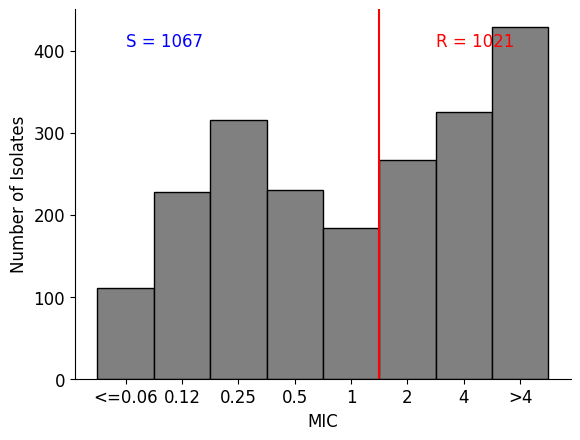

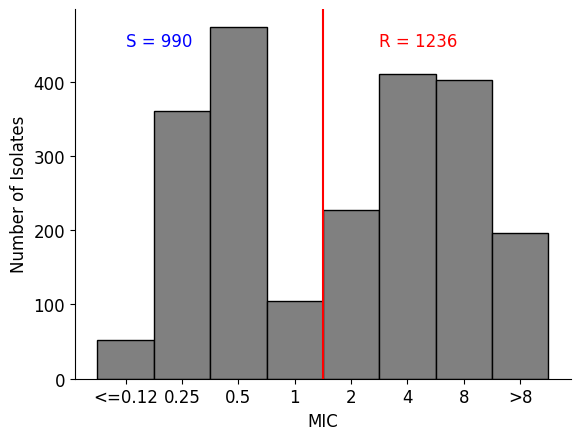

In [178]:
#remove isolates with more than one DNA gyrase mutation and show MIC distribution
mxf=make_ml_dataset(mxf_prep_features,'MXF')
lev=make_ml_dataset(lev_prep_features,'LEV')

In [179]:
#make list of names of features to consider
X_names=["ATOM_CHANGE", "VOLUME_CHANGE", "HYDROPATHY_CHANGE","CHARGE_CHANGE","HDONOR_CHANGE",
         "HACCEPTOR_CHANGE", "ROTABLE_BOND_CHANGE","AROMATIC_RING_CHANGE","SULPHUR_CHANGE","SNAP2_SCORE",
         "RESIDUE_DEPTH","LIGAND_DISTANCE", "CATALYTIC_MG_DISTANCE", "LIGAND_MG_DISTANCE","DNA_DISTANCE", "RSA", 
         "STABILITY_CHANGE", "PROTEIN_HBONDS","DNA_HBONDS", "PP_AFFINITY_CHANGE","GENE_gyrA", "GENE_gyrB", 
         "SECONDARY_STRUCTURE_B","SECONDARY_STRUCTURE_E","SECONDARY_STRUCTURE_G","SECONDARY_STRUCTURE_H", 
         "SECONDARY_STRUCTURE_I","SECONDARY_STRUCTURE_NaN", "SECONDARY_STRUCTURE_S","SECONDARY_STRUCTURE_T", 
         "LINEAGE_NAME_Lineage 1", "LINEAGE_NAME_Lineage 2", "LINEAGE_NAME_Lineage 3","LINEAGE_NAME_Lineage 4",
         "LINEAGE_NAME_Lineage 6", "LIGAND_INTERACTION_NaN", "LIGAND_INTERACTION_none", 
         "LIGAND_INTERACTION_salt_bridge","LIGAND_INTERACTION_water_bridge", "IS_HET", 
            "BACKGROUND_INH_AND_RIF_S",
            "BACKGROUND_INH_MONOR",
            "BACKGROUND_MDR",  
            "BACKGROUND_RIF_MONOR",
            "BACKGROUND_UNKNOWN",
            "COUNTRY_WHERE_SAMPLE_TAKEN_BRA",
            "COUNTRY_WHERE_SAMPLE_TAKEN_CHN",  
            "COUNTRY_WHERE_SAMPLE_TAKEN_DEU", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_IND", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_ITA",  
            "COUNTRY_WHERE_SAMPLE_TAKEN_KGZ",
            "COUNTRY_WHERE_SAMPLE_TAKEN_NPL",
            "COUNTRY_WHERE_SAMPLE_TAKEN_PAK",
            "COUNTRY_WHERE_SAMPLE_TAKEN_PER",
            "COUNTRY_WHERE_SAMPLE_TAKEN_TJK",
            "COUNTRY_WHERE_SAMPLE_TAKEN_TKM",   
            "COUNTRY_WHERE_SAMPLE_TAKEN_UKR",
            "COUNTRY_WHERE_SAMPLE_TAKEN_VNM", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_ZAF" ]
print('number of features considered = ', len(X_names))

number of features considered =  59


In [180]:
#prepare feature set for every possible gyrA/gyrB mutation
every_mutation = pd.read_csv("STRUCTURE_BASED_FEATURES_ALL.csv")
every_mutation.rename(columns = {'MAPP_SCORE':'SNAP2_SCORE'}, inplace = True)
every_mutation_1hot = pd.get_dummies(every_mutation, columns=['GENE'], sparse=True)

feat_list_0=['IS_HET','LINEAGE_NAME_Lineage 1', 
       'LINEAGE_NAME_Lineage 3', 'LINEAGE_NAME_Lineage 4',
       'LINEAGE_NAME_Lineage 6', 'BACKGROUND_INH_AND_RIF_S',
       'BACKGROUND_INH_MONOR',  'BACKGROUND_RIF_MONOR', 
       'BACKGROUND_UNKNOWN', 'COUNTRY_WHERE_SAMPLE_TAKEN_BRA',
        'COUNTRY_WHERE_SAMPLE_TAKEN_DEU','COUNTRY_WHERE_SAMPLE_TAKEN_CHN',
       
       'COUNTRY_WHERE_SAMPLE_TAKEN_ITA', 'COUNTRY_WHERE_SAMPLE_TAKEN_KGZ',
        'COUNTRY_WHERE_SAMPLE_TAKEN_NPL',
       'COUNTRY_WHERE_SAMPLE_TAKEN_PAK', 'COUNTRY_WHERE_SAMPLE_TAKEN_PER',
       'COUNTRY_WHERE_SAMPLE_TAKEN_TJK', 'COUNTRY_WHERE_SAMPLE_TAKEN_TKM',
       'COUNTRY_WHERE_SAMPLE_TAKEN_UKR', 'COUNTRY_WHERE_SAMPLE_TAKEN_VNM',
       'COUNTRY_WHERE_SAMPLE_TAKEN_ZAF']
feat_list_1=['LINEAGE_NAME_Lineage 2', 'BACKGROUND_MDR', 'COUNTRY_WHERE_SAMPLE_TAKEN_IND']

for i in feat_list_0:
    every_mutation_1hot[i]=[0] * len(every_mutation_1hot)
    
for i in feat_list_1:
    every_mutation_1hot[i]=[1] * len(every_mutation_1hot)
    
    
#change numerical values to floats
names = ["POSITION","ATOM_CHANGE", "VOLUME_CHANGE", "HYDROPATHY_CHANGE","CHARGE_CHANGE","HDONOR_CHANGE","HACCEPTOR_CHANGE", 
         "ROTABLE_BOND_CHANGE","AROMATIC_RING_CHANGE","SULPHUR_CHANGE","SNAP2_SCORE","RESIDUE_DEPTH","LIGAND_DISTANCE",
         "LIGAND_MG_DISTANCE", "CATALYTIC_MG_DISTANCE","DNA_DISTANCE", "RSA", "STABILITY_CHANGE", "PROTEIN_HBONDS",
         "DNA_HBONDS","PTR_HBONDS", "LIGAND_HBONDS", "PP_AFFINITY_CHANGE", "GENE_gyrA", "GENE_gyrB", 
         "SECONDARY_STRUCTURE_B","SECONDARY_STRUCTURE_E","SECONDARY_STRUCTURE_G","SECONDARY_STRUCTURE_H", 
         "SECONDARY_STRUCTURE_I","SECONDARY_STRUCTURE_NaN", "SECONDARY_STRUCTURE_S","SECONDARY_STRUCTURE_T", 
         "LINEAGE_NAME_Lineage 1", "LINEAGE_NAME_Lineage 2", "LINEAGE_NAME_Lineage 3","LINEAGE_NAME_Lineage 4",
         "LINEAGE_NAME_Lineage 6", "LIGAND_INTERACTION_NaN", "LIGAND_INTERACTION_none", 
         "LIGAND_INTERACTION_salt_bridge","LIGAND_INTERACTION_water_bridge", "IS_HET", 
            "BACKGROUND_INH_AND_RIF_S",
            "BACKGROUND_INH_MONOR",
            "BACKGROUND_MDR",  
            "BACKGROUND_RIF_MONOR",
            "BACKGROUND_UNKNOWN",
            "COUNTRY_WHERE_SAMPLE_TAKEN_BRA",
            "COUNTRY_WHERE_SAMPLE_TAKEN_CHN",  
            "COUNTRY_WHERE_SAMPLE_TAKEN_DEU", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_IND", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_ITA",  
            "COUNTRY_WHERE_SAMPLE_TAKEN_KGZ",
            "COUNTRY_WHERE_SAMPLE_TAKEN_NPL",
            "COUNTRY_WHERE_SAMPLE_TAKEN_PAK",
            "COUNTRY_WHERE_SAMPLE_TAKEN_PER",
            "COUNTRY_WHERE_SAMPLE_TAKEN_TJK",
            "COUNTRY_WHERE_SAMPLE_TAKEN_TKM",   
            "COUNTRY_WHERE_SAMPLE_TAKEN_UKR",
            "COUNTRY_WHERE_SAMPLE_TAKEN_VNM", 
            "COUNTRY_WHERE_SAMPLE_TAKEN_ZAF" ]
for name in names:
    every_mutation_1hot=every_mutation_1hot.astype({name: float})
    
every_mutation_1hot.to_csv('every_mutation_for_prediction.csv')

In [181]:
#recursive feature elimination for selection of best features
def rfe_rank_features(X,y,model, method):
    '''takes training feature set and training labels, a basic machine learning model, and the prediciton to be made (string: 'binary' or 'mic'),
    returns dataframe of features and their ranks from cross validated recursive feature elimination'''


    if method=='mic':
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42), 
                 scoring=make_scorer(my_accuracy_scorer))
    elif method=='binary':
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42), 
                 scoring='roc_auc')
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)


    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

    rank=rfecv.ranking_
    support=rfecv.support_
    d={'Feature':X_names,'Rank':rank, 'Support':support}
    
    model_name=str(model)
    file_name=model_name.split('(')[0]
    
    
    output = pd.DataFrame(d)

    print(output)
    
    return output

In [182]:
def best_feature_list(ranked_features):
    '''returns list of best features from output of rfe_rank_features()'''
    bad_features= ranked_features[(ranked_features['Rank'] != 1)].index
    best_df=ranked_features.drop(bad_features)
    best_features=best_df.Feature.tolist()
    
    return best_features

In [183]:
def my_accuracy_scorer(y_true, y_probs):
    '''returns accuracy score given true labels and predicited labels'''
    class_predictions=[]
    for j in y_probs:
        if j<0.5:
            class_predictions.append(0)
        if j>=0.5 and j<1.5:
            class_predictions.append(1)
        if j>=1.5 and j<2.5:
            class_predictions.append(2)
        if j>=2.5 and j<3.5:
            class_predictions.append(3)
        if j>=3.5 and j<4.5:
            class_predictions.append(4)
        if j>=4.5 and j<5.5:
            class_predictions.append(5)
        if j>=5.5 and j<6.5:
            class_predictions.append(6)
        if j>=6.5:
            class_predictions.append(7)
    cf = confusion_matrix(y_true, class_predictions, labels=[0,1,2,3,4,5,6,7])
    accuracy = (cf[0][0]+cf[1][1]+cf[2][2]+cf[3][3]+cf[4][4]+cf[5][5]+cf[6][6]+cf[7][7])/len(y_probs)
    
    
    
    return accuracy

In [184]:

def hp_tuning(X,y,model,params,drug, method):
    '''random search hp tuning, takes training features, labels, basic model, dictionary of parameters and values for tuning, drug string and method string (mic/binary),
    returns best model and .csv (method+'_'+str(file_name)+"_training_"+drug+".csv") with training scores from hp tuning of best model and returns best model parameters'''
    

    cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
    
    
    
    n_iter_search = 50
    if method=='mic':
        random_search = RandomizedSearchCV(model, param_distributions=params,
                                   n_iter=n_iter_search, cv=cv, random_state=42, scoring=make_scorer(my_accuracy_scorer))
    elif method=='binary':
        random_search = RandomizedSearchCV(model, param_distributions=params,
                                   n_iter=n_iter_search, cv=cv, random_state=42, scoring='roc_auc')
    random_search.fit(X, y)
    
    results_df = pd.DataFrame(random_search.cv_results_)
    best_mean=np.max(results_df['mean_test_score'])
    bm_index=results_df[(results_df['mean_test_score'] == best_mean)].index
    
                        
    data=results_df.loc[bm_index]
    result_df=data[['split0_test_score','split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score' ]]
    print(result_df)
    
    model_name=str(model)
    file_name=model_name.split('(')[0]
    result_df.to_csv(method+'_'+str(file_name)+"_training_"+drug+".csv")
    
    return random_search.best_estimator_


In [185]:
#fits best model to full training set and predicts on final test set
def test_ml(X_train,y_train,X_test,y_test,model,method,drug,file_name,best_features):
    '''takes training features, trainign labels, test features, tets labels, machine leanring model, prediction to be made (binary/mic), drug string,
    a file name string and the features to use. Returns dataframe containing TRUTH (test set labels), 
    PREDICITON (prediciton for test set) and PROBA (confidence of prediciton - only for binary) and .csv with prediciton for all 
    possbile mutations ('all_predicitons_'+method+'_'+str(file_name)+"_"+drug+".csv")'''
    
    EA=[]
    accuracy=[]
    sensitivity=[]   
    specificity=[]
    class_predictions=[]
    all_pred=[]
    
  

    model.fit(X_train, y_train)
    predictions = model.predict(X_test) 
    proba = model.predict_proba(X_test)

    
    all_muts=pd.read_csv('every_mutation_for_prediction.csv')
    all_muts_x=all_muts[best_features]
    all_muts_x=all_muts_x.reindex(columns=best_features)
    all_muts_x=all_muts_x[best_features].values

    all_prediction=model.predict(all_muts_x)

  
    
    if method=='mic':
        for j in all_prediction:
            if j<0.5:
                all_pred.append(0)
            if j>=0.5 and j<1.5:
                all_pred.append(1)
            if j>=1.5 and j<2.5:
                all_pred.append(2)
            if j>=2.5 and j<3.5:
                all_pred.append(3)
            if j>=3.5 and j<4.5:
                all_pred.append(4)
            if j>=4.5 and j<5.5:
                all_pred.append(5)
            if j>=5.5 and j<6.5:
                all_pred.append(6)
            if j>=6.5:
                all_pred.append(7)
        all_muts['PREDICTION']=all_pred
        all_muts.to_csv('all_predicitons_'+method+'_'+str(file_name)+"_"+drug+".csv")
        for j in predictions:
            if j<0.5:
                class_predictions.append(0)
            if j>=0.5 and j<1.5:
                class_predictions.append(1)
            if j>=1.5 and j<2.5:
                class_predictions.append(2)
            if j>=2.5 and j<3.5:
                class_predictions.append(3)
            if j>=3.5 and j<4.5:
                class_predictions.append(4)
            if j>=4.5 and j<5.5:
                class_predictions.append(5)
            if j>=5.5 and j<6.5:
                class_predictions.append(6)
            if j>=6.5:
                class_predictions.append(7)
        truth=[]
        for i in y_test:
            truth.append(i)
        testing= X_test
        X_test_df=pd.DataFrame(testing)
        X_test_df['TRUTH']=truth
        X_test_df['PREDICTION']=class_predictions
        output_df=X_test_df
    elif method=='binary':
        truth=[]
        for i in y_test:
            truth.append(i)
        testing= X_test
        X_test_df=pd.DataFrame(testing)
        X_test_df['TRUTH']=truth
        X_test_df['PREDICTION']=predictions
        X_test_df['PROBA']=proba[:, 1]
        output_df=X_test_df
        all_muts['PREDICTION']=all_prediction
        all_muts.to_csv('all_predicitons_'+method+'_'+str(file_name)+"_"+drug+".csv")
        
    return output_df

In [186]:

def model_pipeline(basic_model, GS_params, drug, method):
    '''pipeline to run models (runs feature selection, then hyperparameter tuning then fits best model to training set and predicts test set). 
    takes a basic model, prameters to use for grid search (dicitonary), drug string ('LEV'/'MXF') and prediciton type ('binary'/'mic').
    returns .csv file (method+'_'+str(file_name)+"_test_"+drug+".csv") containing test set truth, prediciton and prediciton confidence(for 'binary' only)'''
    ml_data=pd.read_csv('ML_DATA_USED_'+drug+'.csv')
    ml_data['BINARY_PHENOTYPE']=ml_data.BINARY_PHENOTYPE.map(dict(R=1, S=0))
    
    
    features_tidy =ml_data.drop("MIC", axis=1)
    feature_labels = ml_data["MIC"].copy()
    

    
    X_train, X_test, y_train, y_test = train_test_split(features_tidy, feature_labels, random_state=42,
                                                    test_size=0.20, stratify=feature_labels, shuffle=True)
    
    
    X_train.to_csv('train_set_'+drug+'.csv')
    X_test.to_csv('test_set_'+drug+'.csv')

    if method=='binary':
        
        
        y_train = X_train["BINARY_PHENOTYPE"].copy()
        X_train =X_train.drop("BINARY_PHENOTYPE", axis=1)
        y_train.to_csv('train_set_truth_'+drug+'.csv')
        
        
        y_test = X_test["BINARY_PHENOTYPE"].copy()
        X_test =X_test.drop("BINARY_PHENOTYPE", axis=1)
    
    feature_selection=rfe_rank_features(X_train[X_names].values,y_train.values, basic_model, method)

    best_features=best_feature_list(feature_selection)
    print(best_features)

    best_hps = hp_tuning(X_train[best_features].values,
            y_train.values, 
            basic_model,
           GS_params, drug, method)
    print(best_hps)

    model_name=str(basic_model)
    file_name=model_name.split('(')[0]

    
    test_model = test_ml(X_train[best_features].values, y_train.values,
                                   X_test[best_features].values, y_test.values,best_hps,method,drug,file_name,best_features)

    
    
    test_model.to_csv(method+'_'+str(file_name)+"_test_"+drug+".csv")



Optimal number of features : 53


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


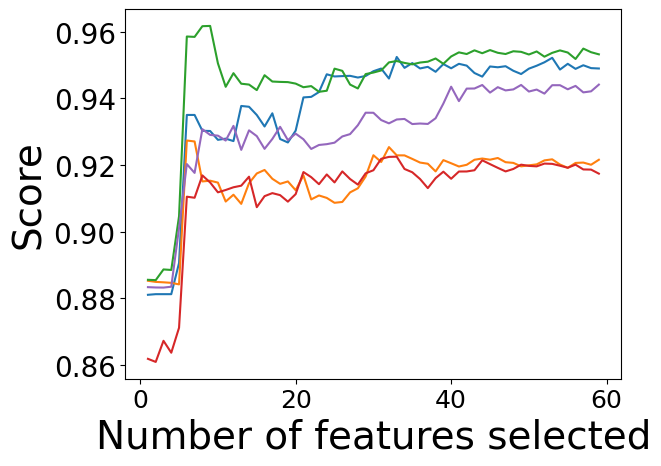

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


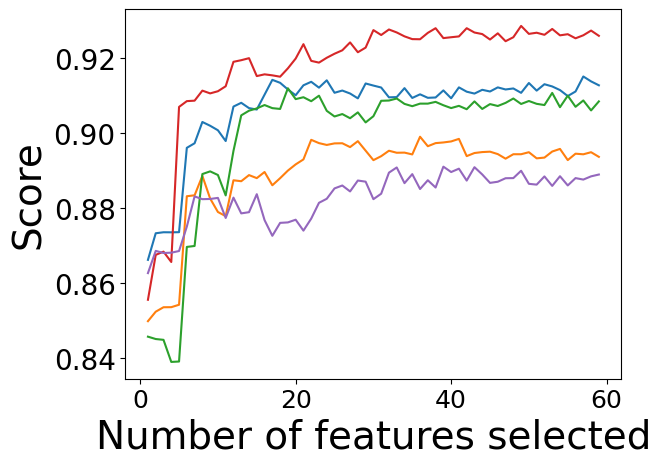

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     9    False
8                    SULPHUR_CHANGE    11    False
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [164]:
#random forest classifier
RFC=model_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced'),{'n_estimators': randint(100,1000), 'max_depth': randint(2,6), 'min_samples_split': randint(2,6), 
           'min_samples_leaf': randint(2,6)}, 'LEV', 'binary')
RFC=model_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced'),{'n_estimators': randint(100,1000), 'max_depth': randint(2,6), 'min_samples_split': randint(2,6), 
           'min_samples_leaf': randint(2,6)}, 'MXF', 'binary')

Optimal number of features : 20


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


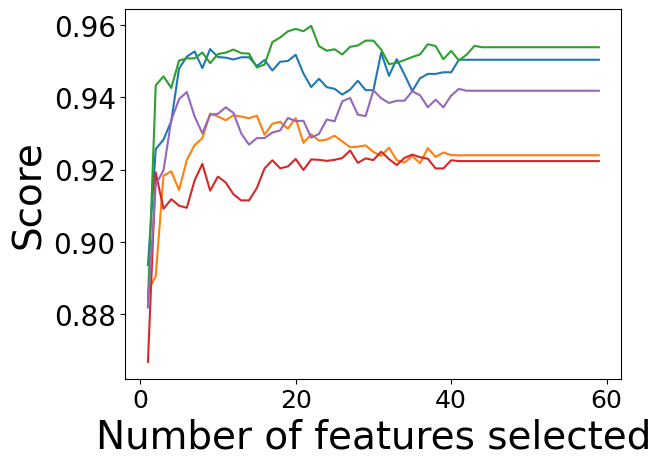

                            Feature  Rank  Support
0                       ATOM_CHANGE     8    False
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     2    False
3                     CHARGE_CHANGE    19    False
4                     HDONOR_CHANGE    16    False
5                  HACCEPTOR_CHANGE     5    False
6               ROTABLE_BOND_CHANGE    12    False
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE    22    False
9                       SNAP2_SCORE     3    False
10                    RESIDUE_DEPTH     6    False
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     9    False
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

Optimal number of features : 34


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


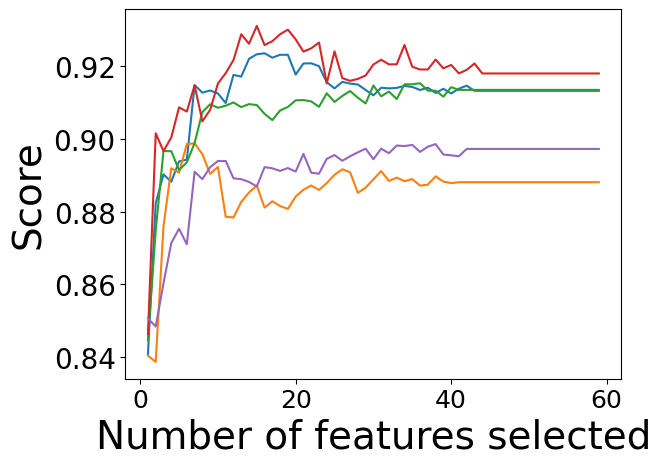

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     7    False
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     9    False
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     3    False
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     4    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [44]:
#XGB classifier
XGB=model_pipeline(xgb.XGBClassifier(random_state = 42, verbosity = 0, use_label_encoder =False), {'n_estimators': randint(100,1000), 'max_depth': randint(2,6),
                                                          'learning_rate': uniform(0.05,0.1)}, 'LEV', 'binary')
XGB=model_pipeline(xgb.XGBClassifier(random_state = 42, verbosity = 0, use_label_encoder =False), {'n_estimators': randint(100,1000), 'max_depth': randint(2,6),
                                                          'learning_rate': uniform(0.05,0.1)}, 'MXF', 'binary')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Optimal number of features : 44


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

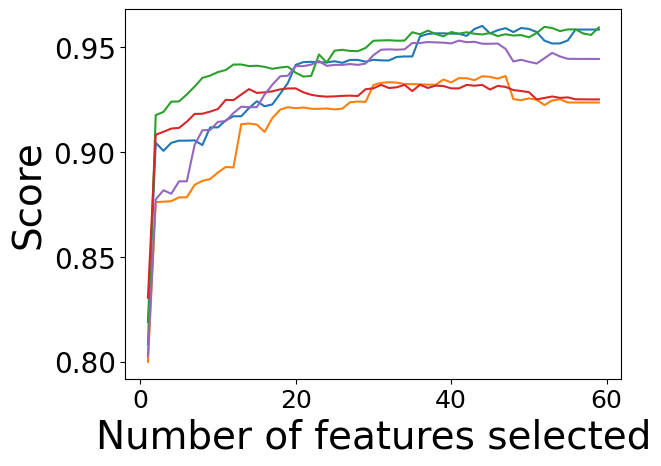

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     5    False
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     6    False
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     2    False
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE    10    False
10                    RESIDUE_DEPTH     4    False
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     3    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     7    False
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
5           0.956773           0.934282           0.957742           0.930316   

   split4_test_score  
5           0.953586  
LogisticRegression(C=3.347086111390218, class_weight='balanced', max_iter=971,
                   random_state=42)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[5.46192998e-01 4.53807002e-01]
 [7.41307889e-01 2.58692111e-01]
 [8.96700465e-02 9.10329954e-01]
 [2.22472914e-01 7.77527086e-01]
 [1.55375898e-01 8.44624102e-01]
 [3.26031369e-02 9.67396863e-01]
 [6.21938144e-02 9.37806186e-01]
 [2.32762355e-01 7.67237645e-01]
 [2.12716575e-01 7.87283425e-01]
 [9.97792222e-01 2.20777813e-03]
 [1.13663495e-01 8.86336505e-01]
 [9.76942133e-01 2.30578672e-02]
 [1.06646484e-01 8.93353516e-01]
 [9.99140787e-01 8.59212682e-04]
 [9.98700645e-01 1.29935464e-03]
 [9.98361313e-01 1.63868697e-03]
 [4.37365921e-02 9.56263408e-01]
 [6.64021555e-01 3.35978445e-01]
 [6.83427369e-02 9.31657263e-01]
 [8.07973577e-02 9.19202642e-01]
 [1.55375898e-01 8.44624102e-01]
 [8.35748108e-01 1.64251892e-01]
 [1.70915564e-01 8.29084436e-01]
 [1.55375898e-01 8.44624102e-01]
 [9.74946026e-01 2.50539743e-02]
 [9.83928381e-02 9.01607162e-01]
 [9.06000453e-02 9.09399955e-01]
 [9.89440472e-01 1.05595284e-02]
 [9.95744163e-01 4.25583732e-03]
 [7.33699795e-01 2.66300205e-01]
 [1.904235

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Optimal number of features : 41


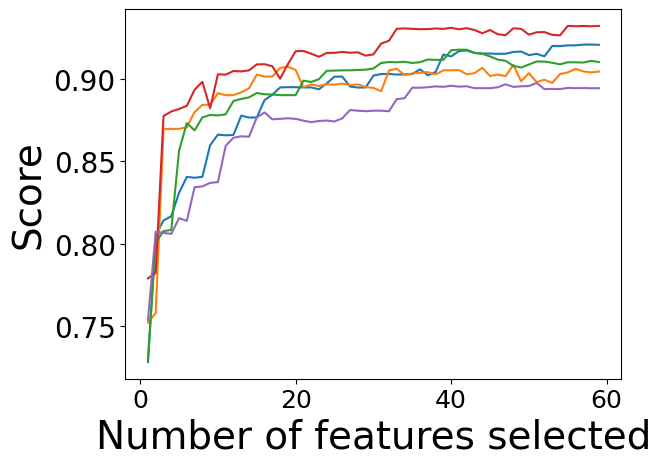

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE    14    False
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE    10    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     7    False
12            CATALYTIC_MG_DISTANCE     2    False
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     8    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
7            0.92075           0.906223           0.916676           0.931905   

   split4_test_score  
7           0.898845  
LogisticRegression(C=0.5741157902710026, class_weight='balanced', max_iter=443,
                   random_state=42)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[1.13388314e-01 8.86611686e-01]
 [9.98802236e-01 1.19776394e-03]
 [3.63839823e-01 6.36160177e-01]
 [2.14819735e-01 7.85180265e-01]
 [9.92839296e-01 7.16070355e-03]
 [9.99692012e-01 3.07987650e-04]
 [9.87133588e-01 1.28664121e-02]
 [2.14819735e-01 7.85180265e-01]
 [1.98441616e-01 8.01558384e-01]
 [4.07197608e-01 5.92802392e-01]
 [9.99447119e-01 5.52881254e-04]
 [4.17233613e-01 5.82766387e-01]
 [9.98779473e-01 1.22052683e-03]
 [8.89678524e-01 1.10321476e-01]
 [4.07197608e-01 5.92802392e-01]
 [8.98697532e-01 1.01302468e-01]
 [6.69889544e-02 9.33011046e-01]
 [3.46363762e-01 6.53636238e-01]
 [9.95426867e-01 4.57313274e-03]
 [9.62856408e-01 3.71435921e-02]
 [9.99703049e-01 2.96951348e-04]
 [1.33147117e-01 8.66852883e-01]
 [1.33147117e-01 8.66852883e-01]
 [9.76146277e-01 2.38537226e-02]
 [9.97707024e-01 2.29297552e-03]
 [1.13388314e-01 8.86611686e-01]
 [2.14819735e-01 7.85180265e-01]
 [6.56718976e-02 9.34328102e-01]
 [9.99802623e-01 1.97377445e-04]
 [1.19552008e-01 8.80447992e-01]
 [9.968935

In [45]:
LR=model_pipeline(LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs'), 
                    {'max_iter': randint(100,1000), 'C': uniform(0.01,10)},'LEV','binary')
LR=model_pipeline(LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs'), 
                    {'max_iter': randint(100,1000), 'C': uniform(0.01,10)},'MXF','binary')

Optimal number of features : 26


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


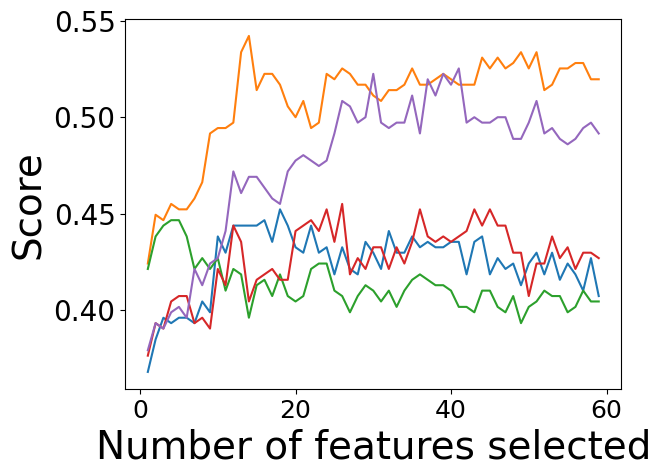

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     6    False
4                     HDONOR_CHANGE     4    False
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE    16    False
8                    SULPHUR_CHANGE    13    False
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     7    False
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


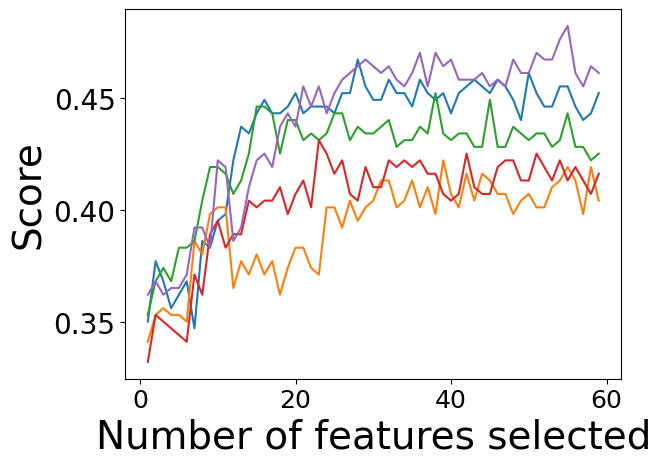

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [1086]:
#random forest classifier
RFC=model_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced'),{'n_estimators': randint(100,1000), 'max_depth': randint(2,6), 'min_samples_split': randint(2,6), 
           'min_samples_leaf': randint(2,6)}, 'LEV','mic')
RFC=model_pipeline(RandomForestClassifier(random_state=42, class_weight='balanced'),{'n_estimators': randint(100,1000), 'max_depth': randint(2,6), 'min_samples_split': randint(2,6), 
           'min_samples_leaf': randint(2,6)}, 'MXF','mic')

Optimal number of features : 34


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


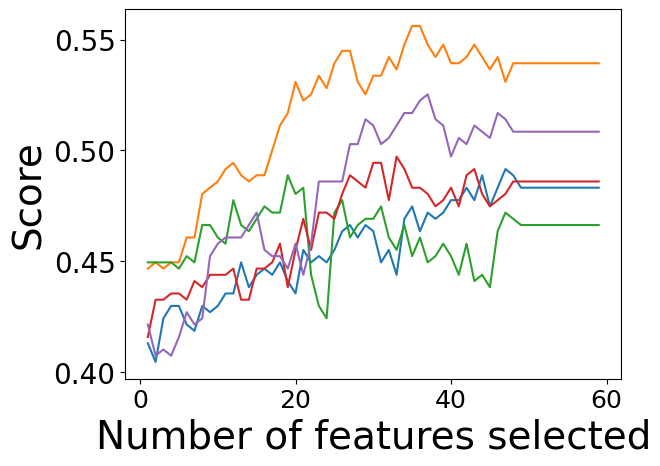

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     9    False
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     7    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


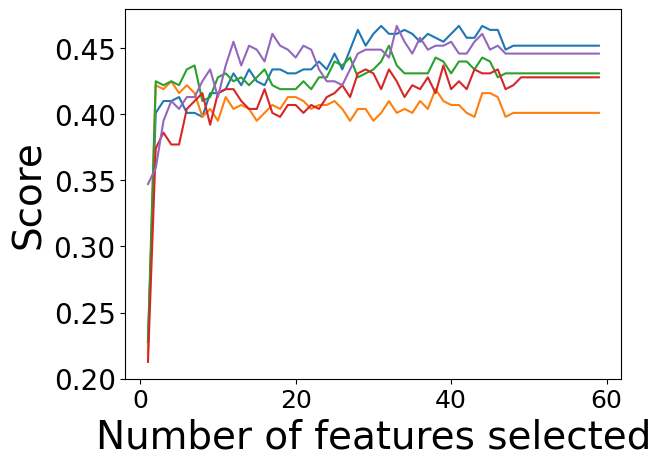

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [1087]:
#XGB classifier
XGB=model_pipeline(xgb.XGBClassifier(random_state = 42, verbosity = 0, use_label_encoder =False), {'n_estimators': randint(100,1000), 'max_depth': randint(2,6),
                                                          'learning_rate': uniform(0.05,0.1)}, 'LEV', 'mic')
XGB=model_pipeline(xgb.XGBClassifier(random_state = 42, verbosity = 0, use_label_encoder =False), {'n_estimators': randint(100,1000), 'max_depth': randint(2,6),
                                                          'learning_rate': uniform(0.05,0.1)}, 'MXF', 'mic')

Optimal number of features : 50


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


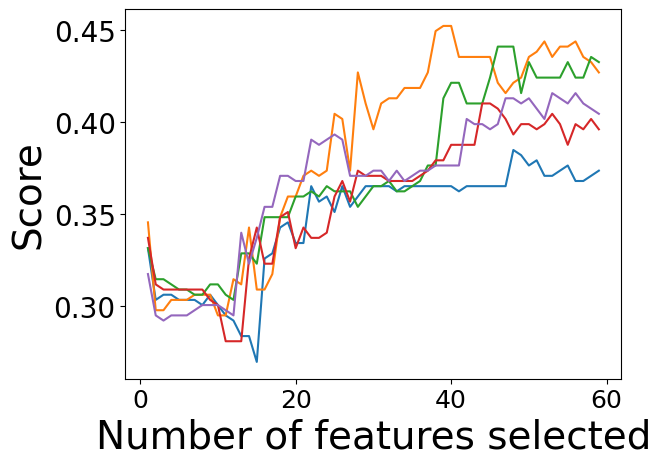

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     4    False
2                 HYDROPATHY_CHANGE     3    False
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     6    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     2    False
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


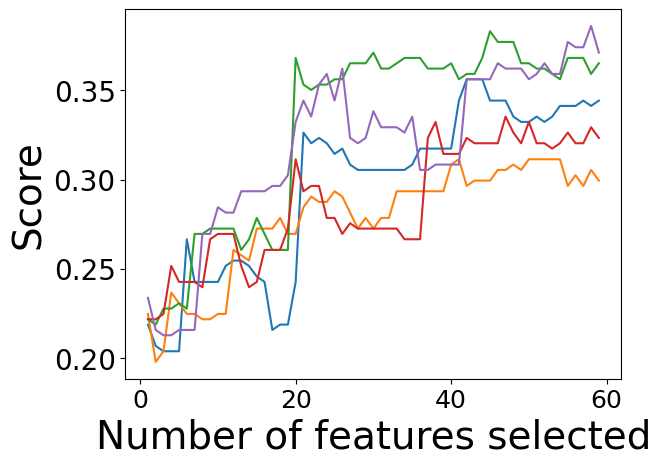

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE    11    False
2                 HYDROPATHY_CHANGE     4    False
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE    10    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     5    False
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     3    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [1088]:
#ordinal all threshold
LOG_AT=model_pipeline(m.LogisticAT(),{'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'LEV', 'mic')
LOG_AT=model_pipeline(m.LogisticAT(),{'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'MXF', 'mic')

Optimal number of features : 51


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


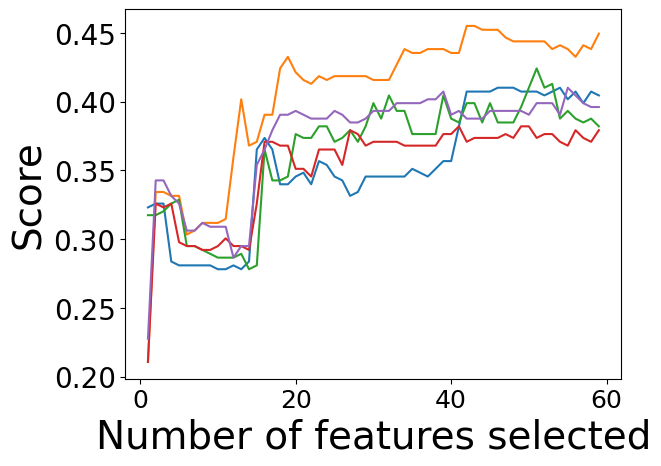

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     4    False
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     6    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     5    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


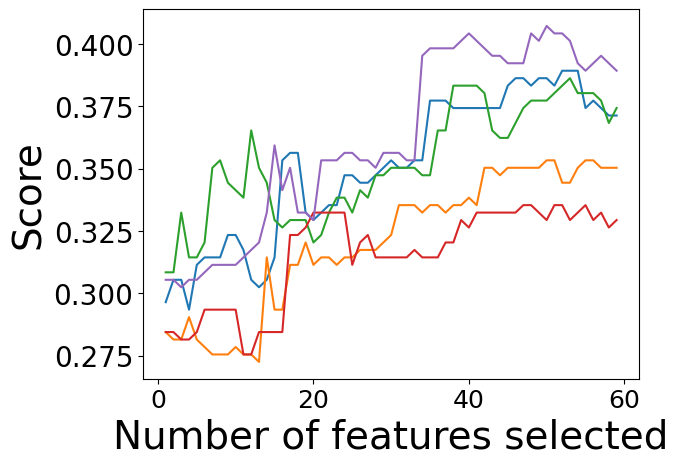

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     5    False
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     6    False
10                    RESIDUE_DEPTH     3    False
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     4    False
18                       DNA_HB

In [1089]:
#ordinal IT
LOG_IT=model_pipeline(m.LogisticIT(), {'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'LEV','mic')
LOG_IT=model_pipeline(m.LogisticIT(), {'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'MXF','mic')

Optimal number of features : 55


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


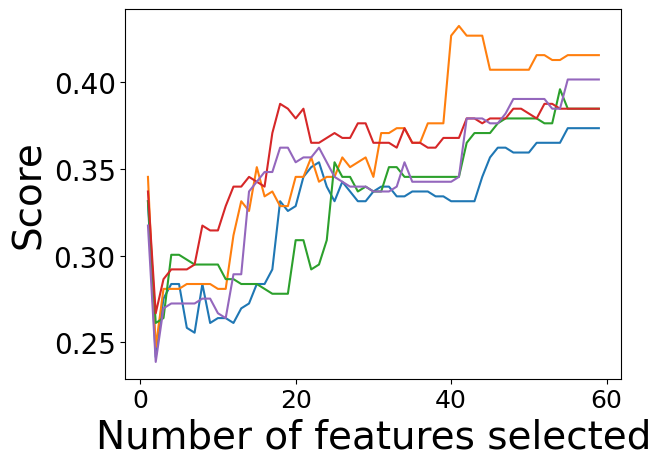

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     1     True
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     2    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


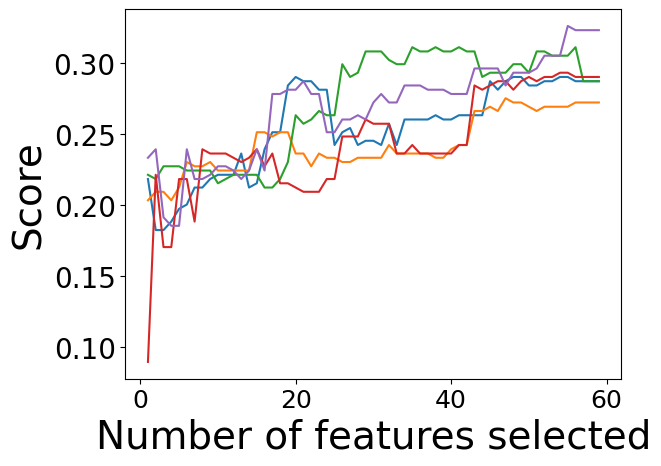

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     1     True
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     3    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     1     True
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [1090]:
#ordinal SE
LOG_SE=model_pipeline(m.LogisticSE(),{'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'LEV','mic')
LOG_SE=model_pipeline(m.LogisticSE(),{'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'MXF','mic')

Optimal number of features : 50


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


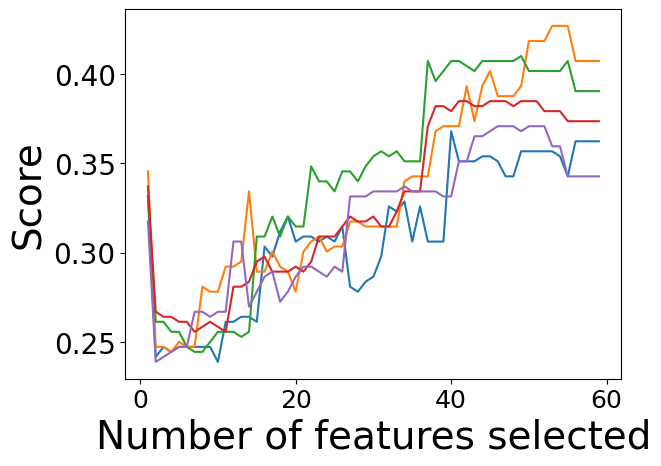

                            Feature  Rank  Support
0                       ATOM_CHANGE     1     True
1                     VOLUME_CHANGE     2    False
2                 HYDROPATHY_CHANGE     3    False
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     7    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     1     True
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     6    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


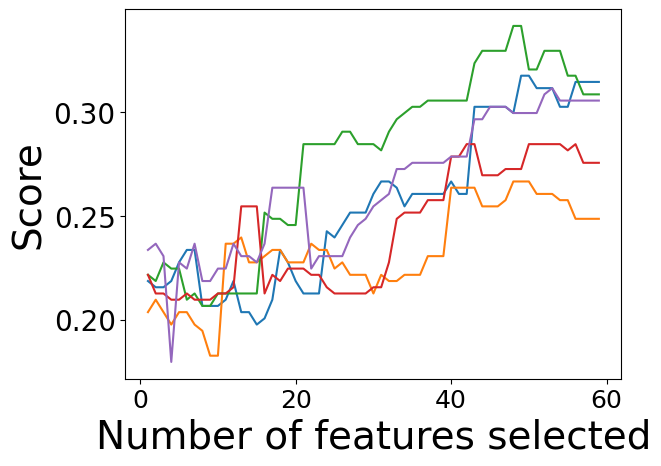

                            Feature  Rank  Support
0                       ATOM_CHANGE     7    False
1                     VOLUME_CHANGE     8    False
2                 HYDROPATHY_CHANGE     1     True
3                     CHARGE_CHANGE     1     True
4                     HDONOR_CHANGE     1     True
5                  HACCEPTOR_CHANGE     1     True
6               ROTABLE_BOND_CHANGE     1     True
7              AROMATIC_RING_CHANGE     1     True
8                    SULPHUR_CHANGE     1     True
9                       SNAP2_SCORE     9    False
10                    RESIDUE_DEPTH     1     True
11                  LIGAND_DISTANCE     1     True
12            CATALYTIC_MG_DISTANCE     2    False
13               LIGAND_MG_DISTANCE     1     True
14                     DNA_DISTANCE     1     True
15                              RSA     6    False
16                 STABILITY_CHANGE     1     True
17                   PROTEIN_HBONDS     1     True
18                       DNA_HB

In [1091]:
#ordinal ridge
ORDR=model_pipeline(m.OrdinalRidge(), {'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'LEV','mic')
ORDR=model_pipeline(m.OrdinalRidge(), {'max_iter': randint(100,1000), 'alpha': uniform(0.01,10)},'MXF','mic')

In [87]:
def mic_graph(f, drug, ax_title, method):
    from matplotlib.ticker import FuncFormatter
    import matplotlib.pyplot as plt
    import numpy as np

    if method=='mic':
        labels=["OAT","OIT","OSE","OR","RFC","XGBC"]
        cmap = plt.get_cmap('viridis')
        colors=cmap(np.linspace(0, 0.9, len(labels)))
    elif method=='binary':
        labels=["LR","RFC","XGBC"]
        cmap = plt.get_cmap('viridis')
        colors=cmap(np.linspace(0, 0.9, len(labels)))

    x = np.arange(len(labels))

    fig, ax = plt.subplots()
    if ax_title=='ROC AUC':
        y= [element for element in f]
        bars=plt.bar(x, y, color=colors,width=0.9)
        plt.xticks(x, labels, size=12)
        plt.yticks(size=12)
        plt.ylim(0,1)
        plt.ylabel(ax_title, size=12)
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{:0.2f}'.format(height), size=10,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    else:
        y= [element * 100 for element in f]
        bars=plt.bar(x, y, color=colors,width=0.9)
        plt.xticks(x, labels, size=12)
        plt.yticks(size=12)
        plt.ylim(0,100)
        plt.ylabel(ax_title, size=12)
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{:0.1f}'.format(height), size=10,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 

    

    plt.savefig(method+'_ML_'+ax_title+'_'+drug+'.png',dpi=300, transparent=True, bbox_inches='tight')
    plt.show()
    

In [119]:
def roc_graph(drug):
    labels=["LR","RFC","XGBC"]
    cmap = plt.get_cmap('viridis')
    colors=cmap(np.linspace(0, 0.9, len(labels)))
    test_files = "binary*test_"+drug+".csv"
    
    test_file_list = sorted(glob.glob(test_files))
    test_file_list = test_file_list[0:]
    
    plt.figure(figsize=(4,4))  
    for i in range(0,len(test_file_list)):
        df = pd.read_csv(test_file_list[i])
        fpr, tpr, _ = roc_curve(df.TRUTH, df.PROBA)

        plt.plot(fpr, tpr, label=labels[i]+' ROC AUC ='+str(round(roc_auc_score(df.TRUTH, df.PROBA),2)), color=colors[i])
        plt.yticks(size=12)
        plt.xticks(size=12)
        plt.xlabel('False Positive Rate', size=12)
        plt.ylabel('True Positive Rate', size=12)
        for pos in ['right', 'top']: 
            plt.gca().spines[pos].set_visible(False) 
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xticks(np.arange(0, 1.1, 0.5))
        plt.yticks(np.arange(0, 1.1, 0.5))
        # show the legend
        plt.legend()
        # show the plot
    plt.savefig('roc_curve_'+drug+'.png',dpi=300, transparent=True, bbox_inches='tight')

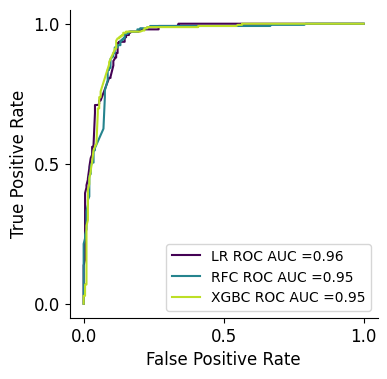

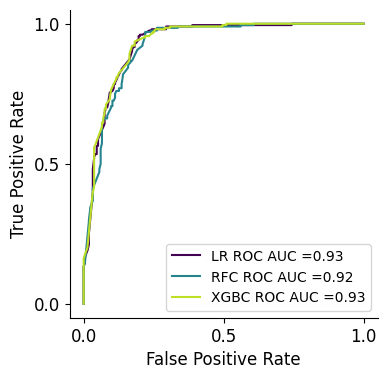

In [120]:
roc_graph('LEV')
roc_graph('MXF')

In [220]:
lev_test_xgb=pd.read_csv("mic_XGBCLassifier_test_LEV.csv")
lev_used=pd.read_csv("ML_DATA_USED_LEV.csv")

In [124]:
#import training and testing file data


def ml_analysis_mic_data(drug, method):
    if method=='mic':
        train_files = "mic*training_"+drug+".csv"
        test_files = "mic*test_"+drug+".csv"
    elif method=='binary':
        train_files = "binary*training_"+drug+".csv"
        test_files = "binary*test_"+drug+".csv"



    train_file_list = sorted(glob.glob(train_files))
    train_file_list = train_file_list[0:]
    print(train_file_list)

    test_file_list = sorted(glob.glob(test_files))
    test_file_list = test_file_list[0:]

    train_y=[]
    train_yerr=[]
    labels=[]

    for file in train_file_list:
        df = pd.read_csv(file, usecols=[1,2,3,4,5])
        train_y.append(df.mean(axis=1)[0])
        train_yerr.append(df.sem(axis=1)[0])
        labels.append(file.split('_')[0])
    
    accuracy=[]
    EA=[]
    sensitivity=[]
    specificity=[]
    auc=[]
    
    if method=='mic':
    
        for file in test_file_list:
            df = pd.read_csv(file)
            cf = confusion_matrix(df.TRUTH, df.PREDICTION, labels=[0,1,2,3,4,5,6,7]) 
            accuracy.append((cf[0][0]+cf[1][1]+cf[2][2]+cf[3][3]+cf[4][4]+cf[5][5]+cf[6][6]+cf[7][7])/len(df)) 
            EA.append((cf[0][0]+cf[1][1]+cf[2][2]+cf[3][3]+cf[4][4]+cf[5][5]+cf[6][6]+cf[7][7]+cf[0][1]+cf[1][0] 
               +cf[1][2]+cf[2][1]+cf[2][3]+cf[3][2]+cf[3][4]+cf[4][3]+cf[4][5]+cf[5][4]+cf[5][6]+cf[6][5] 
               +cf[6][7]+cf[7][6])/len(df)) 
            if drug=='LEV':
                truth_binary = (df.TRUTH>=4)*1 
                pred_binary = (df.PREDICTION>=4)*1
                auc.append(roc_auc_score((df.TRUTH>=4)*1, (df.PREDICTION>=4)*1))
            elif drug=='MXF':
                truth_binary = (df.TRUTH>=5)*1 
                pred_binary = (df.PREDICTION>=5)*1
                auc.append(roc_auc_score((df.TRUTH>=5)*1, (df.PREDICTION>=5)*1))
            sensitivity.append(sum(pred_binary[truth_binary==1])/truth_binary[truth_binary==1].size) 
            specificity.append((pred_binary[truth_binary==0].size - sum(pred_binary[truth_binary==0]))/truth_binary[truth_binary==0].size)
      
    elif method=='binary':
        for file in test_file_list:
            df = pd.read_csv(file)
            truth_binary = (df.TRUTH==1)*1 
            pred_binary = (df.PREDICTION==1)*1
            auc.append(roc_auc_score(df.TRUTH, df.PROBA))
            cf = confusion_matrix(df.TRUTH, df.PREDICTION, labels=[0,1])
            accuracy.append((cf[0][0]+cf[1][1])/len(df))
            sensitivity.append(sum(pred_binary[truth_binary==1])/truth_binary[truth_binary==1].size) 
            specificity.append((pred_binary[truth_binary==0].size - sum(pred_binary[truth_binary==0]))/truth_binary[truth_binary==0].size)
        #graph comparing accuracy between cross validated training set accuracy scores (obtained from best model hp tuning) 
#and accuracy of predicitons on test set
    if method=='mic':
        labels=["OAT","OIT","OSE","OR","RFC","XGBC",]
        cmap = plt.get_cmap('viridis')
        colors=cmap(np.linspace(0, 0.9, len(labels)))
    
    elif method=='binary':
        labels=["LR","RFC","XGBC",]
        cmap = plt.get_cmap('viridis')
        colors=cmap(np.linspace(0, 0.9, len(labels)))


    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots()
    
    if method=='mic':
        rects1 = ax.bar(x - width/2, [element * 100 for element in train_y], width, yerr=[element * 100 for element in train_yerr], capsize=5, label='Train', 
                color='white', edgecolor=colors, hatch='\\')
        rects2 = ax.bar(x + width/2, [element * 100 for element in accuracy], width, label='Test', color=colors)
        ax.set_ylabel('Accuracy', size=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, size=12)
        ax.legend(loc='lower right', prop={'size': 10})
        ax.set_ylim(0,100)
        ax.tick_params(axis='both', which='major', labelsize=12)
    elif method=='binary':
        rects1 = ax.bar(x - width/2, [element for element in train_y], width, yerr=[element for element in train_yerr], capsize=5, label='Train', 
                color='white', edgecolor=colors, hatch='\\')
        rects2 = ax.bar(x + width/2, [element for element in auc], width, label='Test', color=colors)
        ax.set_ylabel('ROC AUC', size=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, size=12)
        ax.legend(loc='lower right', prop={'size': 10})
        ax.set_ylim(0,1)
        ax.tick_params(axis='both', which='major', labelsize=12)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    
    

    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 

    plt.savefig(method+'_ML_TrainvsTest_'+drug+'.png',dpi=300, transparent=True, bbox_inches='tight')
    plt.show()
    
    if method=='mic':
        mic_graph(accuracy,drug, "Accuracy", method)
        mic_graph(EA,drug, "Essential Agreement", method)
        mic_graph(auc,drug, "ROC AUC", method)
    
    if method=='binary':
        mic_graph(auc,drug, "ROC AUC", method)
        mic_graph(accuracy,drug, "Accuracy", method)
    
    mic_graph(sensitivity, drug, 'Sensitivity', method)
    mic_graph(specificity, drug, 'Specificity', method)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)


    for i in enumerate(labels):
 

        ss1 = ax.scatter(sensitivity[i[0]]*100, specificity[i[0]]*100, label=labels[i[0]], marker='x', s=200, color=colors[i[0]])
    


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Specificity', size=12)
    ax.set_xlabel('Sensitivity', size =12)
    ax.set_ylim(min(min(specificity),min(sensitivity))*100-2,100)
    ax.set_xlim(min(min(specificity),min(sensitivity))*100-2,100)

    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 

    ax.legend(loc='lower right')
    ax.tick_params(axis='both', labelsize=12)
    
    texts=[]
    for l in range(len(labels)):
        if sensitivity.count(sensitivity[l])>1 and specificity.count(specificity[l])>1:
            texts.append(plt.text(sensitivity[l]*100, specificity[l]*100, labels[l], size=10))   
            
    print(texts)
    adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k',lw=0.5),
                                                     expand_text=(3,3))
    
    ax.legend(loc='lower left')

    plt.savefig(method+'_ML_SensvsSpec_'+drug+'.png',dpi=300, transparent=True, bbox_inches='tight')

    


['binary_LogisticRegression_training_MXF.csv', 'binary_RandomForestClassifier_training_MXF.csv', 'binary_XGBClassifier_training_MXF.csv']


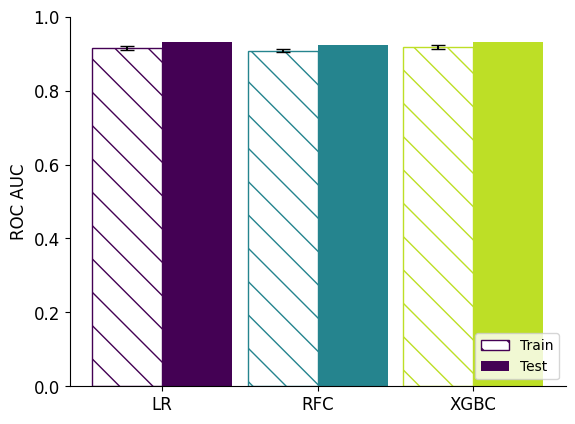

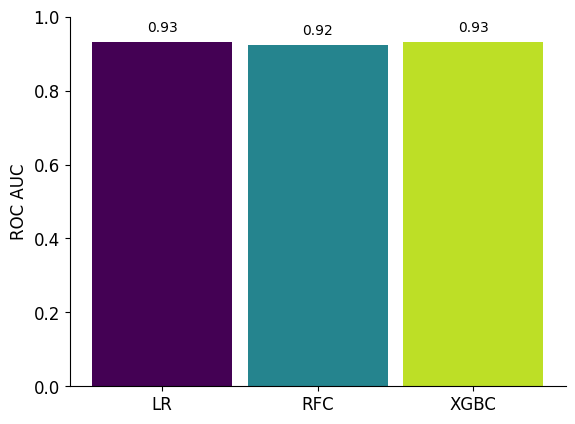

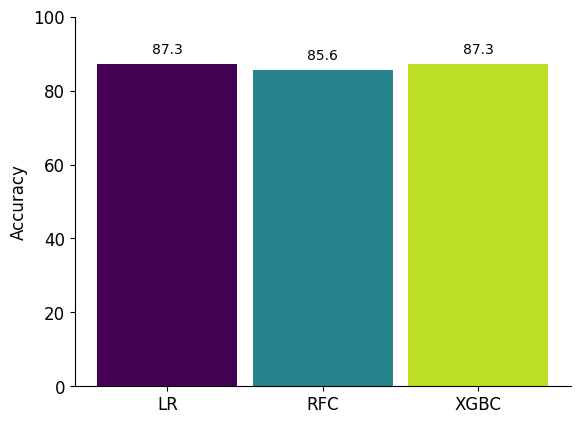

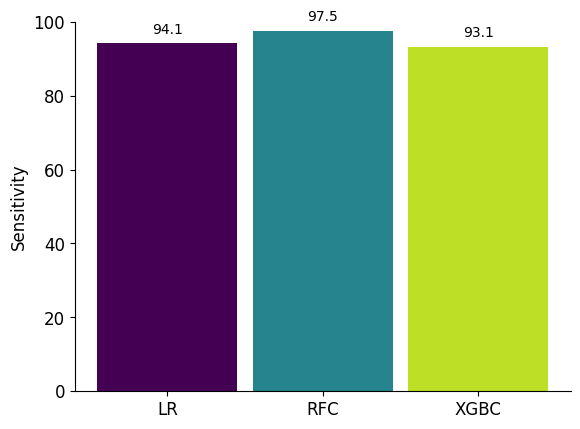

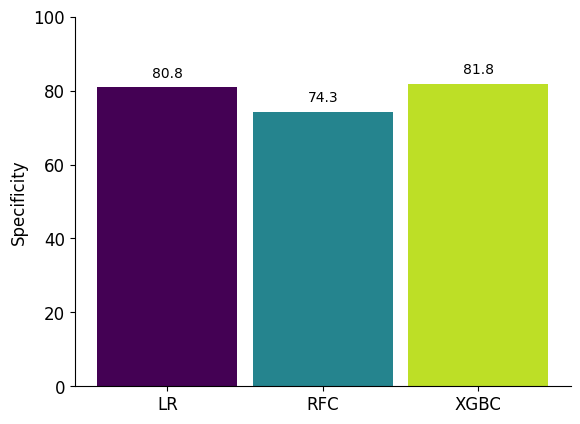

[]


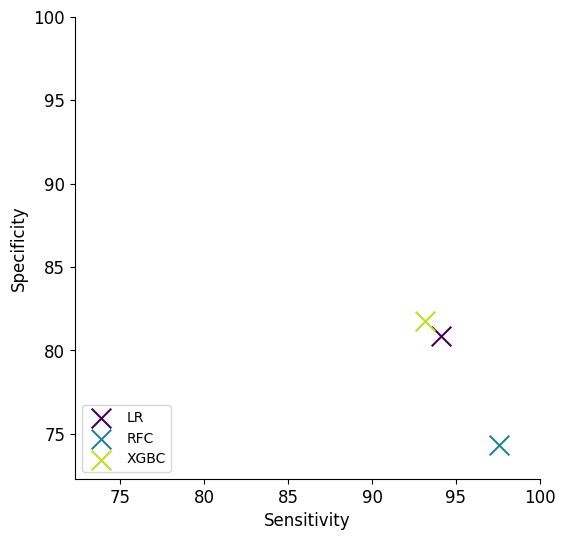

In [125]:
ml_analysis_mic_data('MXF','binary')

['mic_LogisticAT_training_MXF.csv', 'mic_LogisticIT_training_MXF.csv', 'mic_LogisticSE_training_MXF.csv', 'mic_OrdinalRidge_training_MXF.csv', 'mic_RandomForestClassifier_training_MXF.csv', 'mic_XGBClassifier_training_MXF.csv']


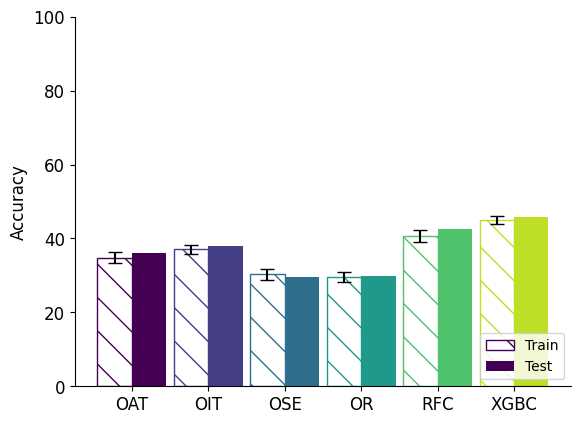

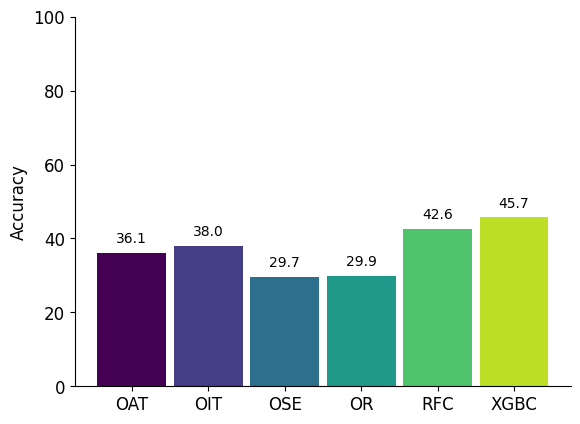

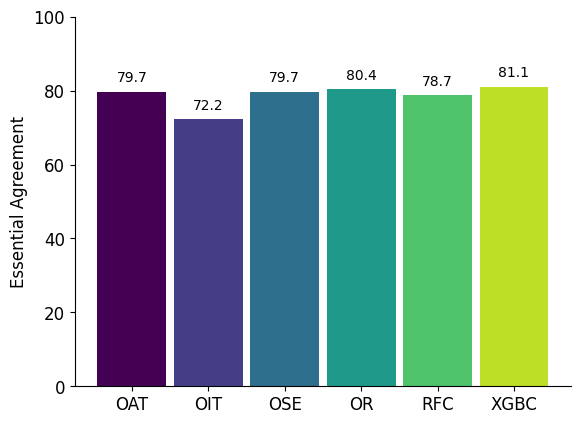

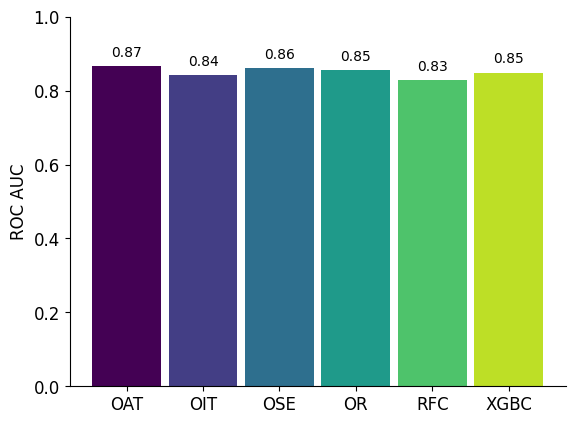

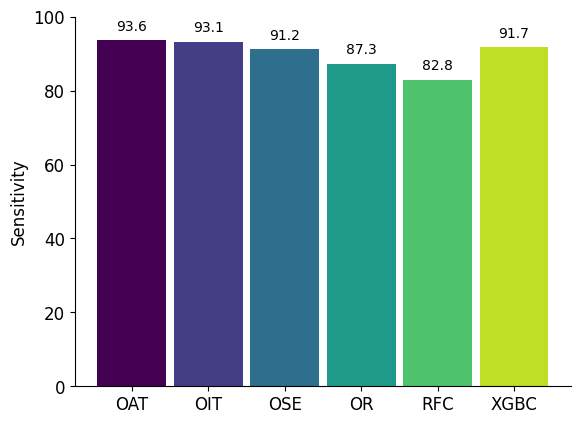

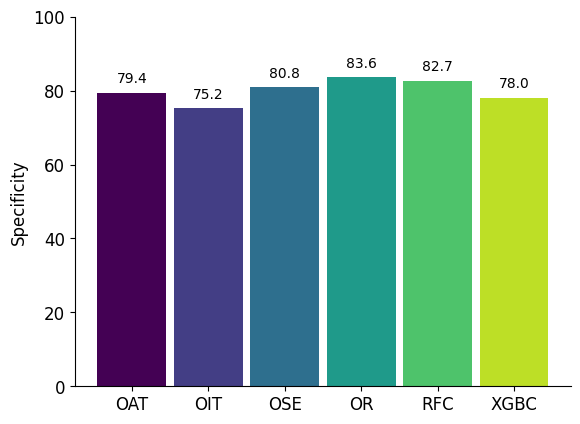

[]


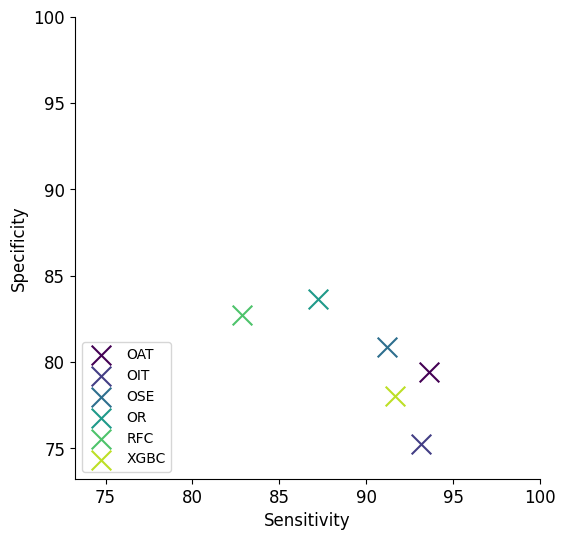

In [126]:
ml_analysis_mic_data('MXF', 'mic')

['binary_LogisticRegression_training_LEV.csv', 'binary_RandomForestClassifier_training_LEV.csv', 'binary_XGBClassifier_training_LEV.csv']


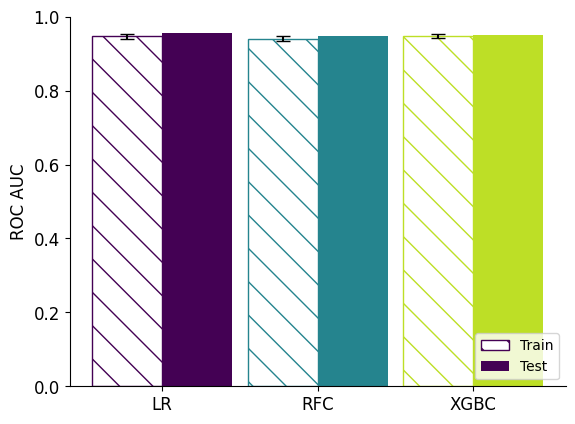

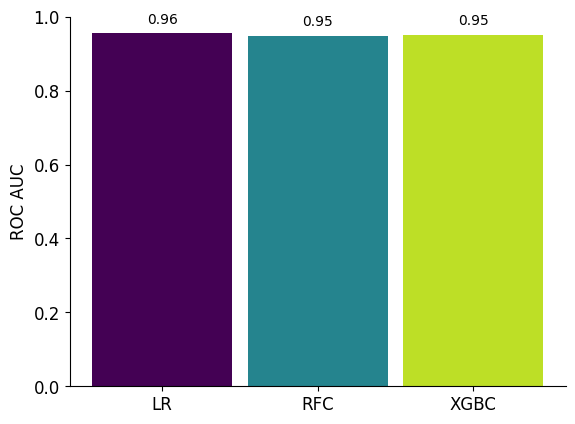

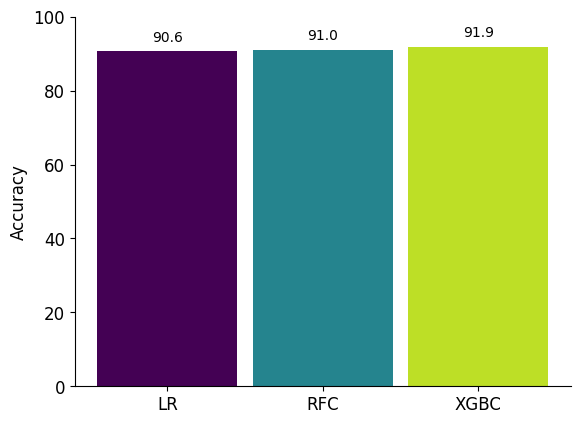

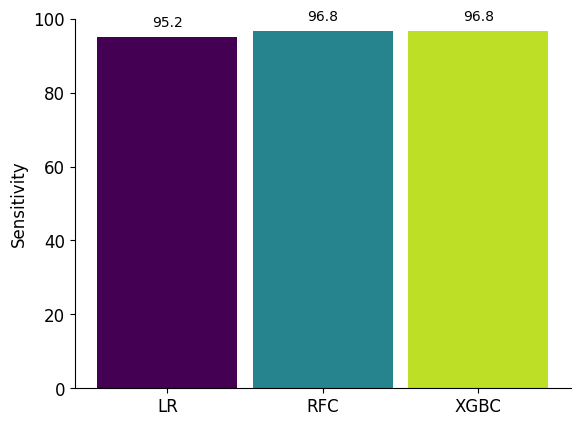

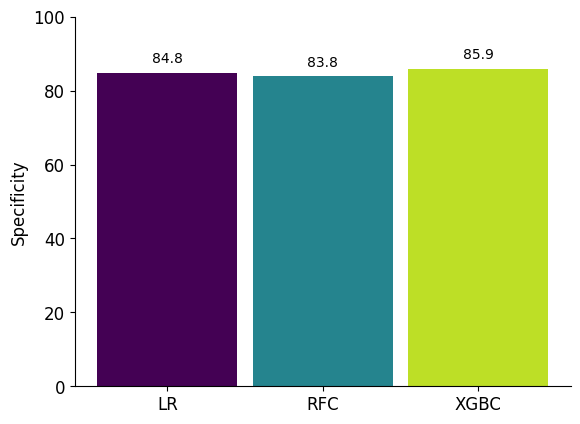

[]


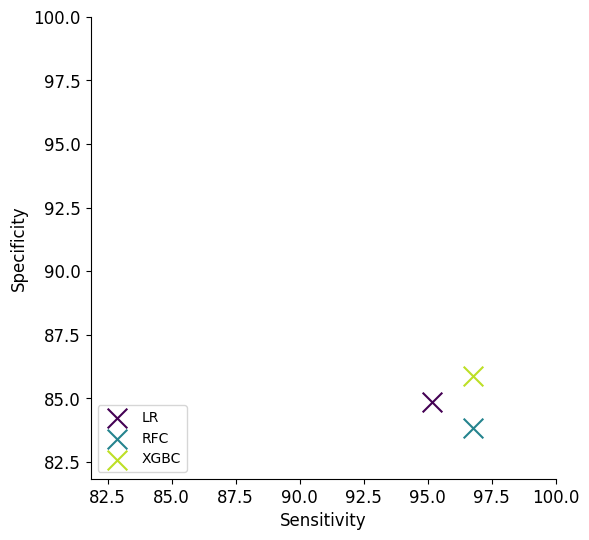

In [127]:
ml_analysis_mic_data('LEV','binary')

['mic_LogisticAT_training_LEV.csv', 'mic_LogisticIT_training_LEV.csv', 'mic_LogisticSE_training_LEV.csv', 'mic_OrdinalRidge_training_LEV.csv', 'mic_RandomForestClassifier_training_LEV.csv', 'mic_XGBClassifier_training_LEV.csv']


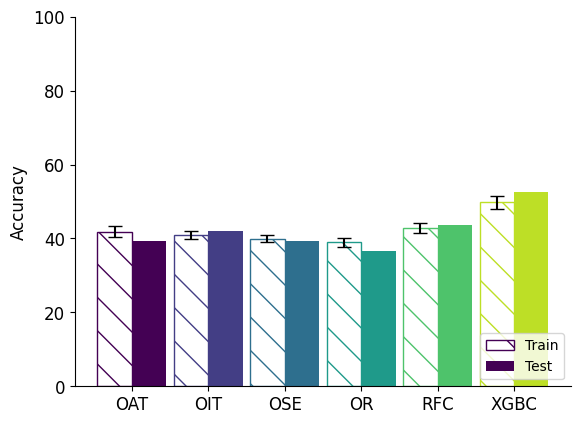

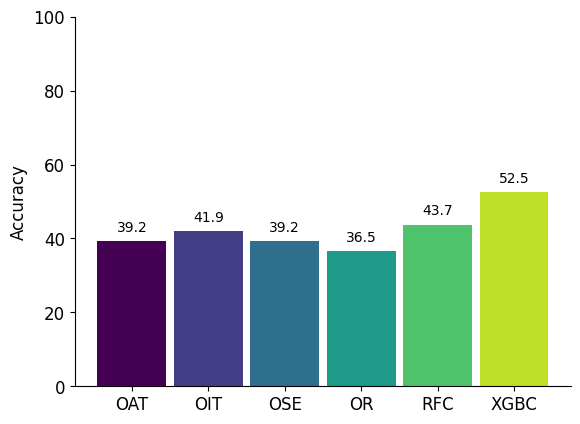

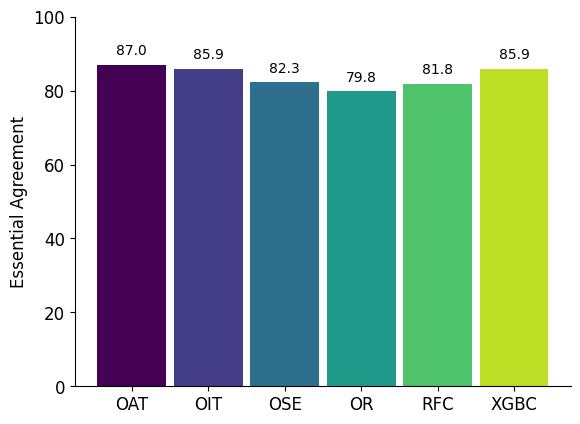

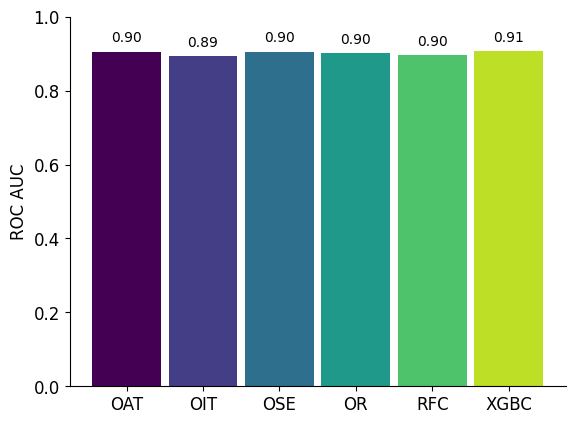

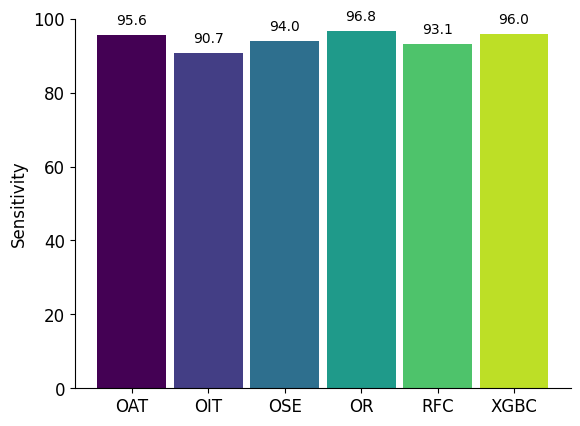

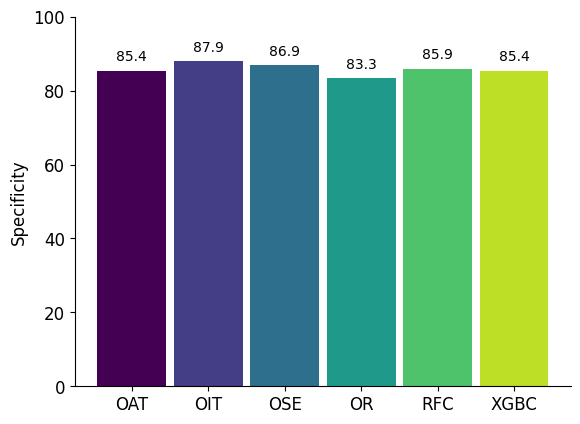

[]


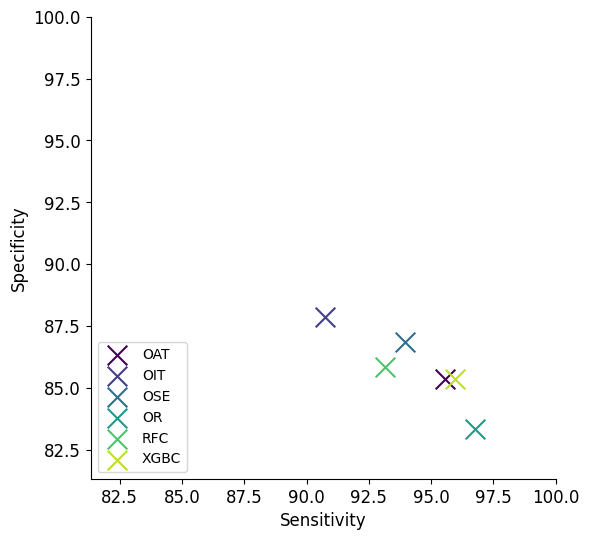

In [116]:
ml_analysis_mic_data('LEV', 'mic')

In [666]:
model=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05159662522202142,
              max_delta_step=0, max_depth=3, min_child_weight=1, 
              monotone_constraints='()', n_estimators=439, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)
X_train=pd.read_csv('train_set_LEV.csv')
X_train=X_train[['VOLUME_CHANGE', 'AROMATIC_RING_CHANGE', 'LIGAND_DISTANCE', 'CATALYTIC_MG_DISTANCE', 'LIGAND_MG_DISTANCE', 'DNA_DISTANCE', 'RSA', 'PROTEIN_HBONDS', 'SECONDARY_STRUCTURE_H', 'LINEAGE_NAME_Lineage 2', 'LINEAGE_NAME_Lineage 4', 'IS_HET', 'BACKGROUND_INH_AND_RIF_S', 'BACKGROUND_MDR', 'COUNTRY_WHERE_SAMPLE_TAKEN_CHN', 'COUNTRY_WHERE_SAMPLE_TAKEN_IND', 'COUNTRY_WHERE_SAMPLE_TAKEN_NPL', 'COUNTRY_WHERE_SAMPLE_TAKEN_PER', 'COUNTRY_WHERE_SAMPLE_TAKEN_VNM', 'COUNTRY_WHERE_SAMPLE_TAKEN_ZAF']]

    

y_train=pd.read_csv('train_set_truth_LEV.csv')
y_train=y_train['BINARY_PHENOTYPE']
model.fit(X_train, y_train)
fi_df_lev=pd.DataFrame(list(zip(['VOLUME_CHANGE', 'AROMATIC_RING_CHANGE', 'LIGAND_DISTANCE', 'CATALYTIC_MG_DISTANCE', 
                                 'LIGAND_MG_DISTANCE', 'DNA_DISTANCE', 'RSA', 'PROTEIN_HBONDS', 'SECONDARY_STRUCTURE_H', 
                                 'LINEAGE_NAME_Lineage 2', 'LINEAGE_NAME_Lineage 4', 'IS_HET', 'BACKGROUND_INH_AND_RIF_S',
                                 'BACKGROUND_MDR', 'COUNTRY_WHERE_SAMPLE_TAKEN_CHN', 'COUNTRY_WHERE_SAMPLE_TAKEN_IND', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_NPL', 'COUNTRY_WHERE_SAMPLE_TAKEN_PER', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_VNM', 'COUNTRY_WHERE_SAMPLE_TAKEN_ZAF'], model.feature_importances_.tolist())), 
                       columns = ['Feature', 'Importance'])
fi_df_lev.sort_values(by=['Importance'], ascending=False)


FileNotFoundError: [Errno 2] No such file or directory: 'XGBClassifier_test_LEV_FN.csv'

In [476]:
model=RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=162, random_state=42)
X_train=pd.read_csv('train_set_MXF.csv')
X_train=X_train[['ATOM_CHANGE', 'VOLUME_CHANGE', 'HYDROPATHY_CHANGE', 'CHARGE_CHANGE', 'HDONOR_CHANGE', 'HACCEPTOR_CHANGE', 'ROTABLE_BOND_CHANGE', 'SNAP2_SCORE', 'RESIDUE_DEPTH', 'LIGAND_DISTANCE', 'CATALYTIC_MG_DISTANCE', 'LIGAND_MG_DISTANCE', 'DNA_DISTANCE', 'RSA', 'STABILITY_CHANGE', 'PROTEIN_HBONDS', 'DNA_HBONDS', 'PP_AFFINITY_CHANGE', 'SECONDARY_STRUCTURE_H', 'SECONDARY_STRUCTURE_NaN', 'LINEAGE_NAME_Lineage 1', 'LINEAGE_NAME_Lineage 2', 'LINEAGE_NAME_Lineage 3', 'LINEAGE_NAME_Lineage 4', 'LIGAND_INTERACTION_NaN', 'LIGAND_INTERACTION_none', 'IS_HET', 'BACKGROUND_INH_AND_RIF_S', 'BACKGROUND_INH_MONOR', 'BACKGROUND_MDR', 'BACKGROUND_UNKNOWN', 'COUNTRY_WHERE_SAMPLE_TAKEN_CHN', 'COUNTRY_WHERE_SAMPLE_TAKEN_DEU', 'COUNTRY_WHERE_SAMPLE_TAKEN_IND', 'COUNTRY_WHERE_SAMPLE_TAKEN_ITA', 'COUNTRY_WHERE_SAMPLE_TAKEN_KGZ', 'COUNTRY_WHERE_SAMPLE_TAKEN_NPL', 'COUNTRY_WHERE_SAMPLE_TAKEN_PAK', 'COUNTRY_WHERE_SAMPLE_TAKEN_PER', 'COUNTRY_WHERE_SAMPLE_TAKEN_TKM', 'COUNTRY_WHERE_SAMPLE_TAKEN_ZAF']]
    

y_train=pd.read_csv('train_set_truth_MXF.csv')
y_train=y_train['BINARY_PHENOTYPE']
model.fit(X_train, y_train)

fi_df_mxf=pd.DataFrame(list(zip(['ATOM_CHANGE', 'VOLUME_CHANGE', 'HYDROPATHY_CHANGE', 'CHARGE_CHANGE', 'HDONOR_CHANGE', 
                                 'HACCEPTOR_CHANGE', 'ROTABLE_BOND_CHANGE', 'SNAP2_SCORE', 'RESIDUE_DEPTH', 
                                 'LIGAND_DISTANCE', 'CATALYTIC_MG_DISTANCE', 'LIGAND_MG_DISTANCE', 'DNA_DISTANCE', 
                                 'RSA', 'STABILITY_CHANGE', 'PROTEIN_HBONDS', 'DNA_HBONDS', 'PP_AFFINITY_CHANGE', 
                                 'SECONDARY_STRUCTURE_H', 'SECONDARY_STRUCTURE_NaN', 'LINEAGE_NAME_Lineage 1', 
                                 'LINEAGE_NAME_Lineage 2', 'LINEAGE_NAME_Lineage 3', 'LINEAGE_NAME_Lineage 4', 
                                 'LIGAND_INTERACTION_NaN', 'LIGAND_INTERACTION_none', 'IS_HET', 'BACKGROUND_INH_AND_RIF_S',
                                 'BACKGROUND_INH_MONOR', 'BACKGROUND_MDR', 'BACKGROUND_UNKNOWN', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_CHN', 'COUNTRY_WHERE_SAMPLE_TAKEN_DEU', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_IND', 'COUNTRY_WHERE_SAMPLE_TAKEN_ITA', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_KGZ', 'COUNTRY_WHERE_SAMPLE_TAKEN_NPL', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_PAK', 'COUNTRY_WHERE_SAMPLE_TAKEN_PER', 
                                 'COUNTRY_WHERE_SAMPLE_TAKEN_TKM', 'COUNTRY_WHERE_SAMPLE_TAKEN_ZAF'], model.feature_importances_.tolist())), 
                       columns = ['Feature', 'Importance'])
fi_df_mxf.sort_values(by=['Importance'], ascending=False)

,UNIQUEID,DRUG,MIC,LOG2MIC,BINARY_PHENOTYPE,PHENOTYPE_QUALITY,MUTATION,POSITION,GENEMUT,IS_HET,...,COUNTRY_WHERE_SAMPLE_TAKEN_KGZ,COUNTRY_WHERE_SAMPLE_TAKEN_NGA,COUNTRY_WHERE_SAMPLE_TAKEN_NPL,COUNTRY_WHERE_SAMPLE_TAKEN_PAK,COUNTRY_WHERE_SAMPLE_TAKEN_PER,COUNTRY_WHERE_SAMPLE_TAKEN_TJK,COUNTRY_WHERE_SAMPLE_TAKEN_TKM,COUNTRY_WHERE_SAMPLE_TAKEN_UKR,COUNTRY_WHERE_SAMPLE_TAKEN_VNM,COUNTRY_WHERE_SAMPLE_TAKEN_ZAF
1209,site.11.subj.XTB-18-196.lab.XTB-18-196.iso.1,LEV,4,1.0,R,MEDIUM,N499D,499.0,gyrBN499D,0.0,...,0,0,0,0,0,0,0,0,0,0
1288,site.11.subj.XTB-18-195.lab.XTB-18-195.iso.1,LEV,5,2.0,R,MEDIUM,N499D,499.0,gyrBN499D,0.0,...,0,0,0,0,0,0,0,0,0,0
1298,site.11.subj.XTB_17-536.lab.XTB_17-536.iso.1,LEV,5,2.0,R,MEDIUM,N499D,499.0,gyrBN499D,0.0,...,0,0,0,0,0,0,0,0,0,0
1364,site.11.subj.XTB-18-252.lab.XTB-18-252.iso.1,LEV,5,2.0,R,MEDIUM,N499D,499.0,gyrBN499D,0.0,...,0,0,0,0,0,0,0,0,0,0
1558,site.10.subj.YA00046971.lab.YA00046971.iso.1,LEV,5,2.0,R,HIGH,N499D,499.0,gyrBN499D,0.0,...,0,0,0,0,0,0,0,0,0,1


In [1164]:
gyra_df_lev

,POSITION,PREDICTED R MUTATIONS
0,R26,"[F, H, Y]"
1,D30,"[F, H, W, Y]"
2,Y31,[W]
3,I36,[F]
4,V37,[H]
...,...,...
62,Q305,[H]
63,L346,[F]
64,Y364,[W]
65,D367,"[F, H, W, Y]"


In [1074]:
lev_or.loc[(lev_or.GENE_gyrB==1)&(lev_or.PREDICTION==1)].POSITION.unique()

array([429., 441., 446., 454., 459., 460., 461., 462., 468., 481., 482.,
       483., 484., 485., 495., 499., 503., 536., 539., 540., 550., 557.,
       570., 572., 587., 588., 589., 595., 611., 615., 619., 623., 631.,
       634., 642., 659., 661., 665.])

In [1075]:
lev_or.loc[(lev_or.GENE_gyrA==1)&(lev_or.PREDICTION==1)].POSITION.unique()

array([ 26.,  30.,  31.,  36.,  37.,  39.,  40.,  41.,  43.,  48.,  49.,
        51.,  52.,  55.,  61.,  70.,  72.,  73.,  74.,  77.,  78.,  81.,
        85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
        96.,  97.,  98., 101., 105., 106., 109., 116., 122., 123., 124.,
       125., 126., 127., 128., 129., 130., 133., 134., 143., 162., 173.,
       181., 278., 279., 280., 281., 285., 289., 305., 346., 364., 367.,
       490.])

In [1131]:
lev_or.loc[(lev_or.GENE_gyrA==1)&(lev_or.PREDICTION==1)&(lev_or.POSITION==40)]

,Unnamed: 0,Unnamed: 0.1,OLD_AA,POSITION,NEW_AA,ATOM_CHANGE,VOLUME_CHANGE,HYDROPATHY_CHANGE,CHARGE_CHANGE,HDONOR_CHANGE,...,COUNTRY_WHERE_SAMPLE_TAKEN_PER,COUNTRY_WHERE_SAMPLE_TAKEN_TJK,COUNTRY_WHERE_SAMPLE_TAKEN_TKM,COUNTRY_WHERE_SAMPLE_TAKEN_UKR,COUNTRY_WHERE_SAMPLE_TAKEN_VNM,COUNTRY_WHERE_SAMPLE_TAKEN_ZAF,LINEAGE_NAME_Lineage 2,BACKGROUND_MDR,COUNTRY_WHERE_SAMPLE_TAKEN_IND,PREDICTION
741,741,741,A,40.0,C,1.0,19.9,0.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
742,742,742,A,40.0,D,3.0,22.5,-5.3,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
743,743,743,A,40.0,E,6.0,49.8,-5.3,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
744,744,744,A,40.0,F,10.0,101.3,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
746,746,746,A,40.0,H,7.0,64.6,-5.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
747,747,747,A,40.0,I,9.0,78.1,2.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
748,748,748,A,40.0,K,11.0,80.0,-5.7,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
749,749,749,A,40.0,L,9.0,78.1,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
750,750,750,A,40.0,M,7.0,74.3,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
752,752,752,A,40.0,P,4.0,24.1,-3.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1


In [ ]:
['gyrAS95T','gyrAE21Q','gyrAT80A','gyrAA90G','gyrAG247S','gyrAA384V',
             'gyrAG668D','gyrAL712V', 'gyrAS250A','gyrAR252L','gyrAL398F','gyrAA463S','gyrAD639A','gyrAV742L',
              'gyrBV301L','gyrBM291I','gyrBA403S']

In [ ]:
['gyrAG88A','gyrAG88C','gyrAA90V','gyrAS91P','gyrAD94A','gyrAD94G','gyrAD94H','gyrAD94N','gyrAD94Y', 
          'gyrBD461N', 'gyrBN499D', 'gyrBE501D', 'gyrBE501V', 'gyrBA504V']

In [ ]:
uniform(0.05,0.1)